# Use VAEs to compress segmented microbiome datasets from lab microbiome (of relative abundance)

Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we first train VAE models with different latents to compress segmented time series of n ASVs from laboratory microbiome dataset (Fujita et al. 2023 Microbiome). We then check the relationship between the explained variance and the latent dimension

In [1]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import time as timer
import pickle

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

'cuda:0'

# VAE Network
The VAE network has 16 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 30) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.channels = 16

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.std_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * 30),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var


def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."

    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha * KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## define utility functions
- load the data
- train, test the model

In [4]:
def get_data(sample,n_target,test_rep):
    arr = np.arange(1, 9, 1)
    excluded = np.array([test_rep])
    train_arr = np.setdiff1d(arr, excluded)
    X_train = []
    for i in train_arr:
        rep = np.load("./lab_microbiome_datasets_CV/%s/%s_T%i_rep%i.npy" %
                (sample, sample, n_target, i))
        X_train.append(rep)
    X_train = np.vstack(X_train)
    X_test = np.load("./lab_microbiome_datasets_CV/%s/%s_T%i_rep%i.npy" %
            (sample, sample, n_target, test_rep))
    return X_train, X_test

In [5]:
def train_model(model, data_loader, optimizer, device = "cuda:0"):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred, code, mu, log_var = model(batch)
        loss = vae_loss(pred, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader, device = "cuda:0"):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            pred, code, mu, log_var = model(batch)
            loss = vae_loss(pred, batch, mu, log_var)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

# Example: training a single VAE model on the relative abundance data

### embedding = 10

In [6]:
def run(sample,n_target,n_embedding,X_train,X_test):
    lr = 5e-4
    lr_decay = 0.95
    batch_size = 64
    EPOCHS = 30
    X_train = torch.Tensor(X_train).float()
    X_test = torch.Tensor(X_test).float()
    train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(X_test,batch_size=batch_size,shuffle=False)

    model = VAE(n_target,n_embedding)
    model.to("cuda:0");
    model.train()
    train_losses=[]
    test_losses=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for ix_epoch in trange(EPOCHS):
        train_err=train_model(model, train_loader, optimizer)
        test_err=test_model(model, test_loader)
        train_losses.append(train_err)
        test_losses.append(test_err)
        # Exponential decay for learning rate
        lr *= lr_decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    print("%i-dim, %i-target model training finished, with starting MSE %1.1e, and ending error %1.1e"%(n_embedding,n_target,test_losses[0],test_losses[-1]))
    return model,train_losses, test_losses

In [7]:
sample="Water-A"
n_target=2
n_embedding=10
test_rep = 8
X_train, X_test = get_data(sample,n_target,test_rep)
model,train_loss,test_loss = run(sample,n_target,n_embedding,X_train,X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

10-dim, 2-target model training finished, with starting MSE 8.3e-03, and ending error 1.3e-03


(13218, 2, 30) (2462, 2, 30)


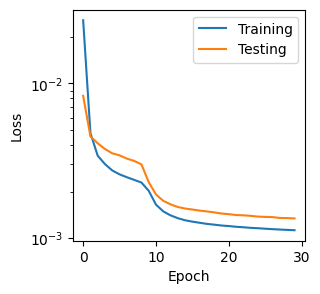

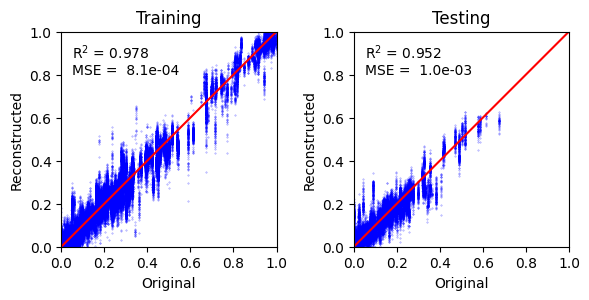

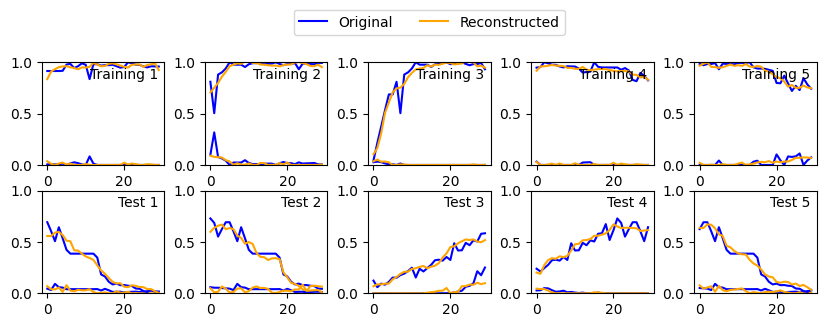

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
print(X_train.shape,X_test.shape)
# Plotting the loss values
plt.figure(figsize=(3, 3))
plt.semilogy(train_loss, label='Training')
plt.semilogy(test_loss, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum


test_data=torch.Tensor(X_test)
sums = test_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, _, _, _ = model(train_data.to(device))
    output_test, _, _, _ = model(test_data.to(device))

output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.5
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

# Training data trajectories
idx_show = np.random.choice(ranked_indices_train[0:400],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[0, i].plot(train_data[idx,j], color='blue')
        axs[0, i].plot(output_train[idx,j], color='orange')
    axs[0, i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[0,i].transAxes)
    axs[0, i].set_ylim([0,1])
axs[0,2].plot([], label='Original', color='blue')
axs[0,2].plot([], label='Reconstructed', color='orange')
axs[0,2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
# Testing data trajectories
idx_show = np.random.choice(ranked_indices_test[0:400],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[1, i].plot(test_data[idx,j], color='blue')
        axs[1, i].plot(output_test[idx,j], color='orange')
    axs[1, i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[1,i].transAxes)
    axs[1, i].set_ylim([0,1])

plt.subplots_adjust(hspace=0.25,wspace=0.33)
plt.show()


# Visualize the training outcome

# visualize the reconstruction as a sanity check

In [9]:
def visualize(axes,sample,n_target,n_embedding,n_show,X_test,test_rep,trial):
    model = VAE(n_target,n_embedding)
    model.load_state_dict(torch.load("./vae_models_CV/%s_T%i_E%i_rep%i_trial%i.pth"%
           (sample,n_target,n_embedding,test_rep,trial),weights_only=True))
    model.to("cuda:0");
    model.eval()

    test_data=X_test*1
    sums = test_data.sum(dim=(1,2))  # Shape: (B,)
    ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum
    with torch.no_grad():
        output_test, _, _, _ = model(test_data.to(device))

    # Squeeze the output to match the original data dimension
    output_test = output_test.cpu().numpy()
    
    # Testing data trajectories
    np.random.seed(42)
    idx_show = np.random.choice(ranked_indices_test[0:200],n_show,replace=False)
    for i,idx in enumerate(idx_show):
        ax=axes[i]
        for j in range(n_target):
            ax.plot(test_data[idx,j], label='Original', color='blue')
            ax.plot(output_test[idx,j], label='Reconstructed', color='orange')
        ax.set_ylim([0,1])
        if i==0:
            ax.set_title(f'latent dim: {n_embedding}')
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax=axes[-1]
    # Testing data plot
    ax.scatter(test_data[:400,:,:].flatten(), output_test[:400,:,:].flatten(), s=0.1, color='blue', alpha=0.5)
    ax.plot([0,1], [0,1], 'r')  # y=x line
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_aspect('equal', adjustable='box')
    r2_test = r2_score(test_data.flatten(), output_test.flatten())
    mse_test = np.square(test_data-output_test).mean()
    ax.text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}', transform=ax.transAxes, verticalalignment='top')

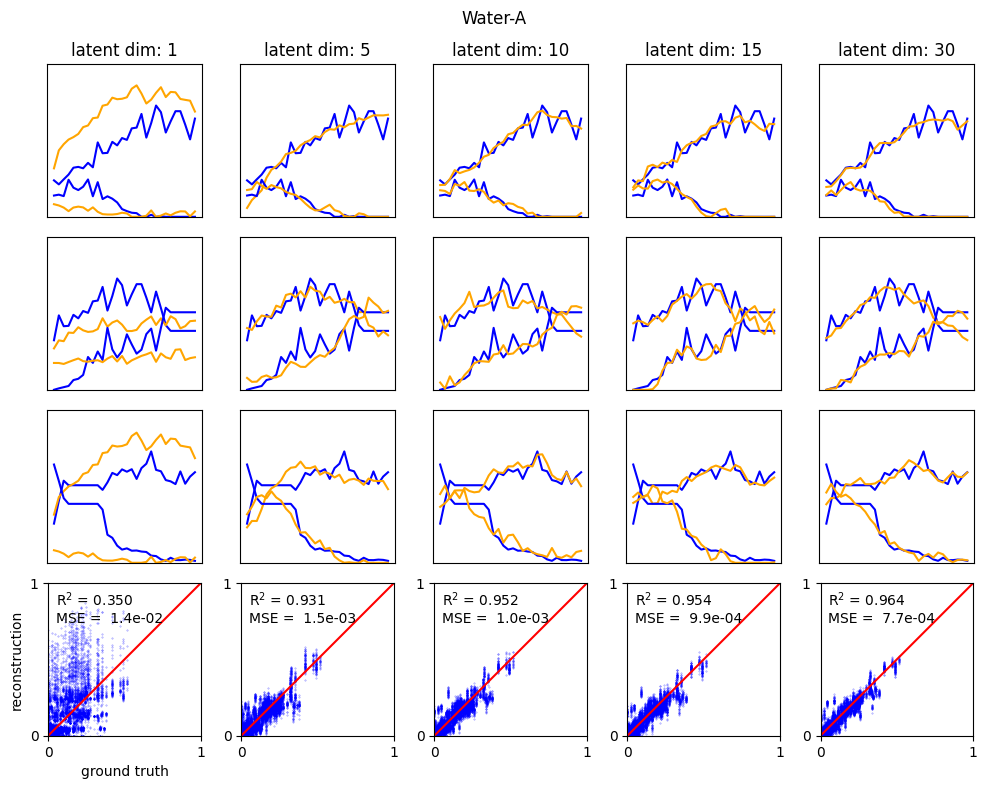

In [10]:
sample = "Water-A"
n_target = 2
test_rep = 8
trial = 1
X_train, X_test = get_data(sample,n_target,test_rep)
X_test = torch.Tensor(X_test).float()
N_EBD=[1,5,10,15,30]
n_show = 3
fig,axes = plt.subplots(n_show+1,len(N_EBD),figsize=(2*len(N_EBD),2*(n_show+1)))
for i, n_embedding in enumerate(N_EBD):
    visualize(axes[:,i],sample,n_target,n_embedding,n_show,X_test,test_rep,trial)
    ax0=axes[0,i]
ax=axes[-1,0]
ax.set_xlabel("ground truth")
ax.set_ylabel("reconstruction")
fig.suptitle(sample)
fig.tight_layout()

# Determine the critical dimension
**to calculate the FUV, code below this point requires downloading the entire dataset from Zenodo; but statistical analysis can be performed with `lab_microbiome_embedding_FUV_CV` folder.**

# Get the FUV - embedding relationship

In [8]:
NT = [1,2,3,4,5]
N_EBD = np.array([1,2,3,4,5,6,8,10,12,15,20,30])
for sample in ["Soil-A","Soil-B","Soil-C","Water-A","Water-B"]:
    for i,n_target in enumerate(NT):
        R2_train = np.zeros((8*3,len(N_EBD)))
        R2_test = np.zeros((8*3,len(N_EBD)))
        for j in range(8):
            test_rep = j+1
            X_train, X_test = get_data(sample,n_target,test_rep)
            X_train = torch.Tensor(X_train).float()
            X_test = torch.Tensor(X_test).float()
            for k,n_embedding in enumerate(N_EBD):
                for trial in range(3):
                    model = VAE(n_target,n_embedding)
                    model.load_state_dict(torch.load("./vae_models_CV/%s_T%i_E%i_rep%i_trial%i.pth"%
                           (sample,n_target,n_embedding,test_rep,trial+1),weights_only=True))
                    model.to("cuda:0");
                    model.eval()
                    with torch.no_grad():
                        reconstruction_train,_,_,_ = model(X_train.to("cuda:0"))
                        reconstruction_train = reconstruction_train.cpu()
                        mse_train = F.mse_loss(X_train,reconstruction_train)
                        r2_train = r2_score(X_train.flatten(), reconstruction_train.flatten())
                        R2_train[3*j+trial,k]=r2_train
                        
                        reconstruction_test,_,_,_ = model(X_test.to("cuda:0"))
                        reconstruction_test = reconstruction_test.cpu()
                        mse_test = F.mse_loss(X_test,reconstruction_test)
                        r2_test = r2_score(X_test.flatten(), reconstruction_test.flatten())

                        R2_test[3*j+trial,k]=r2_test
        R2_train = np.array(R2_train)
        R2_test = np.array(R2_test)
        FUV_train = (1-R2_train)*100
        FUV_test = (1-R2_test)*100
        data_train = np.vstack([N_EBD,FUV_train])
        np.savetxt("./lab_microbiome_embedding_FUV_CV/%s_T%i_train.txt"%(sample,n_target),data_train)
        data_test = np.vstack([N_EBD,FUV_test])
        np.savetxt("./lab_microbiome_embedding_FUV_CV/%s_T%i_test.txt"%(sample,n_target),data_test)
    print(f"{sample} finished")

Soil-A finished
Soil-B finished
Soil-C finished
Water-A finished
Water-B finished


## visualize the FUV - embedding relationship
**statistical analyses below this point can be performed with `lab_microbiome_embedding_FUV_CV` folder.**

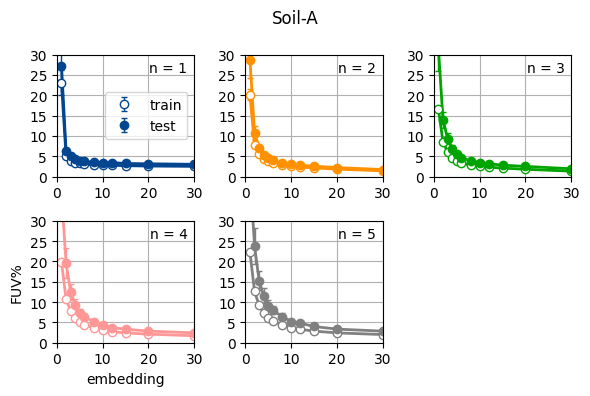

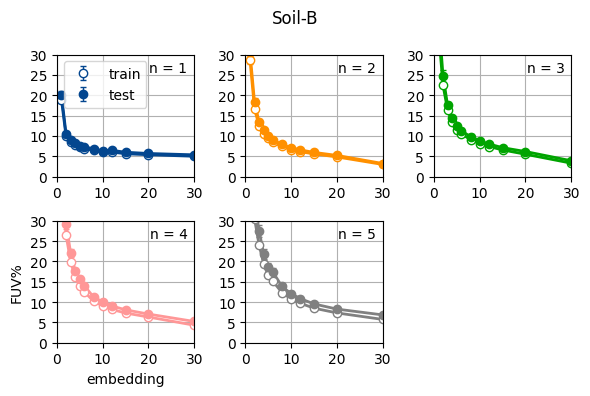

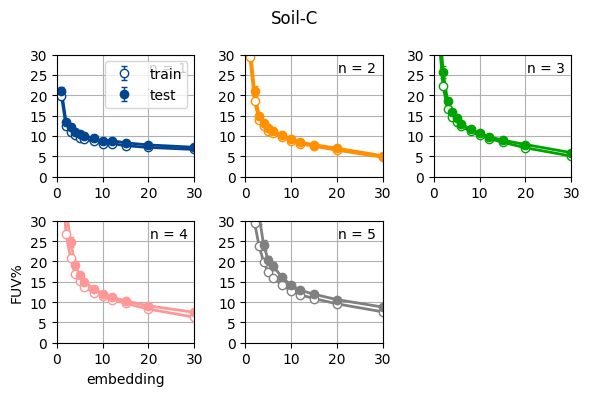

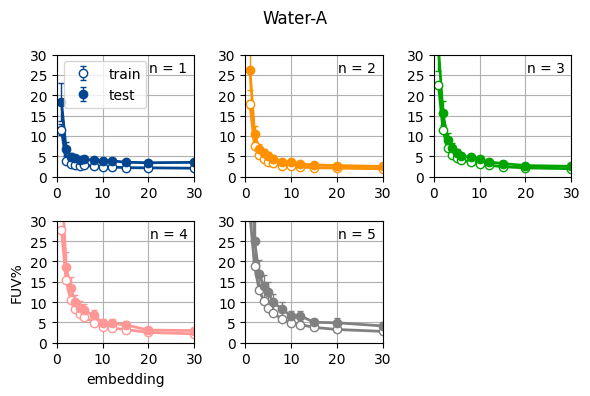

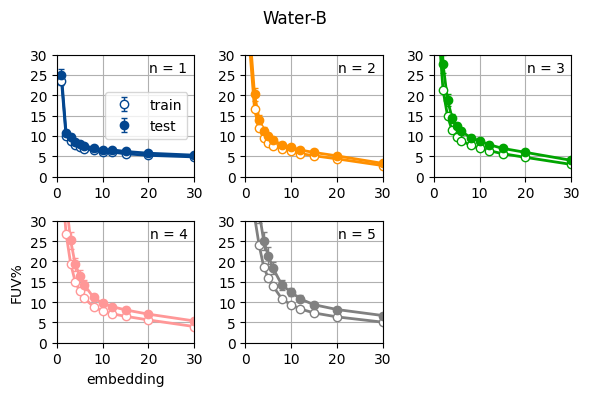

In [9]:
colors = ['#03468F', '#FF9000','#00A400','#FF9797','#808080',]
for sample in ["Soil-A","Soil-B","Soil-C","Water-A","Water-B"]:
    fig,axes1 = plt.subplots(2,3,figsize=(6,4))
    axes1=axes1.flat
    N_TG = [1,2,3,4,5]
    for i in range(len(N_TG)):
        ax1 = axes1[i]
        n_target=N_TG[i]
        for s in ["train","test"]:
            data=np.loadtxt("./lab_microbiome_embedding_FUV_CV/%s_T%i_%s.txt"%(sample,n_target,s))
            N_EBD=data[0,:]
            FUV = data[1:,:]
            n_reps = FUV.shape[0]
            mean_FUV=np.mean(FUV,axis=0)
            std_FUV = np.std(FUV,axis=0,ddof=1)
            se_FUV = std_FUV/np.sqrt(n_reps)
            if s=="train":
                ax1.errorbar(N_EBD,mean_FUV,se_FUV,marker="o",c=colors[i],mfc="w",capsize=2,label=s,lw=0,
                            elinewidth=1)
            else:
                ax1.errorbar(N_EBD,mean_FUV,se_FUV,marker="o",c=colors[i],mfc=colors[i],capsize=2,label=s,lw=0,
                            elinewidth=1)
            ax1.plot(N_EBD,mean_FUV,color=colors[i],lw=2)

        ax1.text(x=0.95,y=0.95,s=f"n = {n_target}",ha="right",va="top",transform=ax1.transAxes)
        ax1.set_yticks(np.arange(0,40,5))
        ax1.set_xticks(np.arange(0,31,10))
        ax1.set_ylim([0,30])
        ax1.set_xlim([0,30])
        ax1.grid(True)
    axes1[3].set_xlabel("embedding")
    axes1[3].set_ylabel("FUV%")
    axes1[-1].set_visible(False)
    axes1[0].legend()
    fig.suptitle(sample)
    fig.tight_layout()
    fig.savefig(f"./figures/{sample}_CV.png",dpi=300)

# Estimate the critical dimension for different number of observables, by determining the Ec that gives FUV = 10%
* FUV = 10% is saved as {sample}_Ec.txt and {sample}_Ec_bootstrap.txt (to be called by the downstream MLP model)
* FUV = 12% and 15% are saved as {sample}_Ec_FUV={y_target}.txt and {sample}_Ec_bootstrap_FUV={y_target}.txt

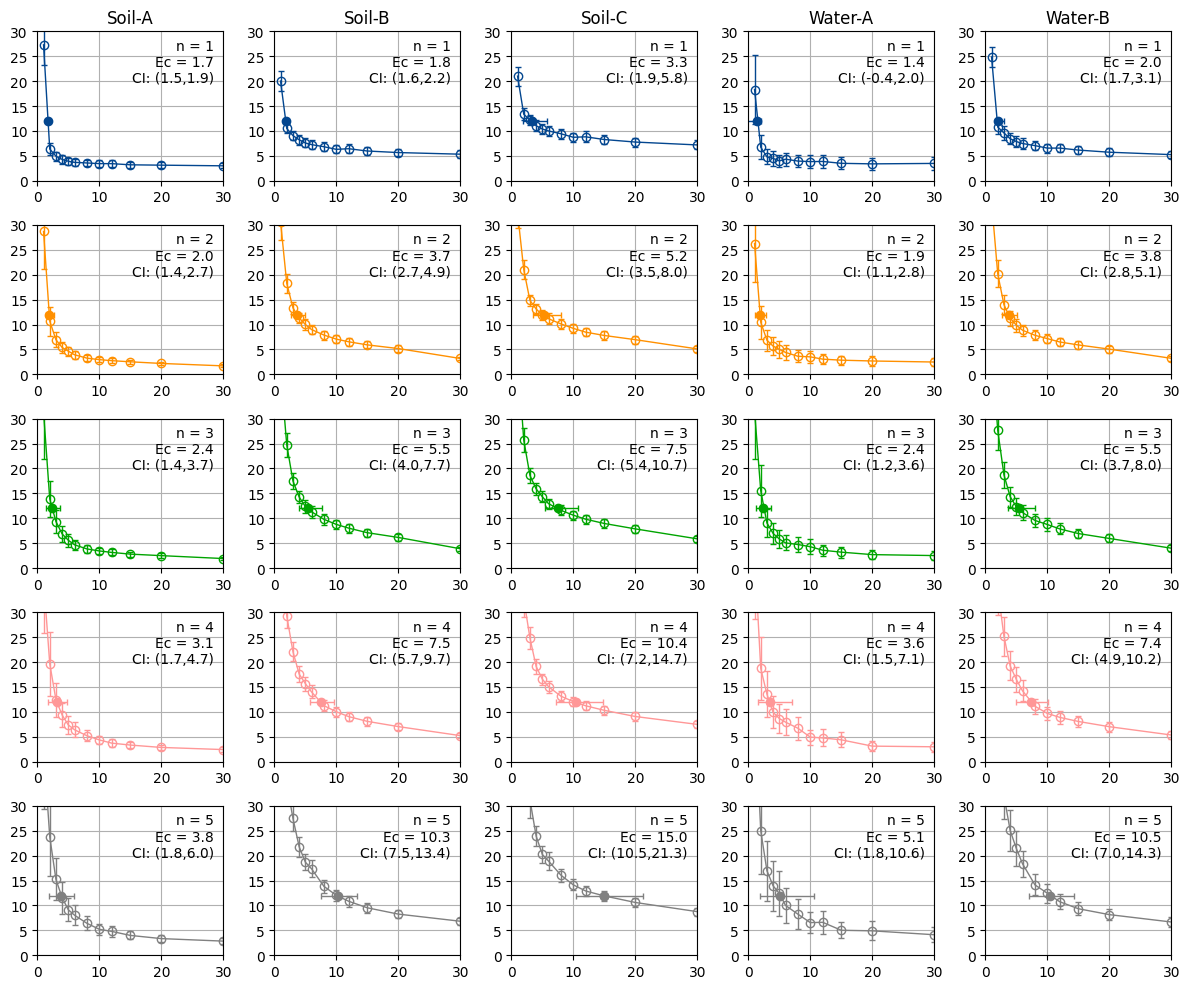

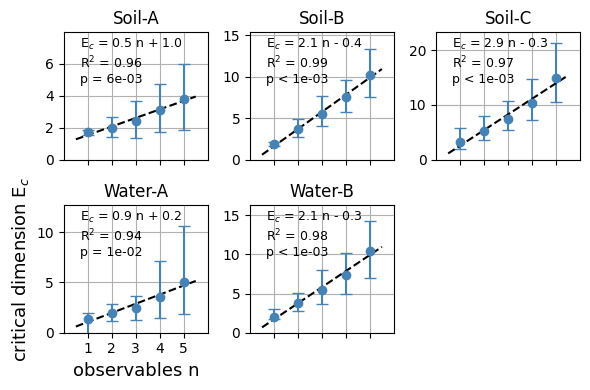

In [6]:
from scipy.interpolate import interp1d
from sklearn.utils import resample

# Parameters
y_target = 12
n_boot = 1000
colors = ['#03468F', '#FF9000', '#00A400', '#FF9797', '#808080']
samples = ["Soil-A", "Soil-B", "Soil-C", "Water-A", "Water-B"]
N_TG = np.arange(1,6,1)

fig, axes = plt.subplots(5, 5, figsize=(12, 10))
fig2, axes2 = plt.subplots(2, 3, figsize=(6,4))
axes2=axes2.flat

for j, sample in enumerate(samples):
    #y_target = fuv_target[sample]
    bootstrap_Ec = np.zeros((4, 5))
    bootstrap_Ec[0, :] = N_TG
    Ec_boot_matrix = np.zeros((n_boot, len(N_TG)))

    for i, n_target in enumerate(N_TG):
        ax1 = axes[i, j]
        data = np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_T{n_target}_test.txt")
        N_EBD = data[0, :]
        FUV = data[1:, :]

        FUV_reshaped = []
        for k in range(8):
            FUV_reshaped.append(FUV[3*k:3*(k+1),:])
        FUV_reshaped = np.array(FUV_reshaped)

        FUV = np.mean(FUV_reshaped,axis=1)# FUV across 8-fold cross validation, each averaged across 3 replicates of VAEs

        # Step 1: Plot mean FUV
        mean_FUV = FUV.mean(axis=0)
        std_FUV = np.std(FUV, axis=0, ddof=1)
        se_FUV = std_FUV / np.sqrt(FUV.shape[0])
        ax1.errorbar(N_EBD, mean_FUV, se_FUV, marker="o", c=colors[i], mfc="None", capsize=2, lw=0, elinewidth=1)
        ax1.plot(N_EBD, mean_FUV, c=colors[i], lw=1)

        # Step 2: Bootstrap Ec
        Ec_boots = []
        for _ in range(n_boot):
            fold_indices = np.random.choice(8, size=8, replace=True)
            boot_FUV = FUV[fold_indices]        # shape (8, 10)
            boot_mean_FUV = boot_FUV.mean(axis=0)  # shape (10,)
            boot_interp = interp1d(boot_mean_FUV[::-1], N_EBD[::-1], bounds_error=False, fill_value="extrapolate")
            Ec_boots.append(boot_interp(y_target))
        Ec_boots = np.array(Ec_boots)
        Ec_boot_matrix[:, i] = Ec_boots
        Ec_ci_lower, Ec_ci_upper = np.percentile(Ec_boots, [2.5, 97.5])
        Ec_mean = np.mean(Ec_boots)
        bootstrap_Ec[1, i] = Ec_mean
        bootstrap_Ec[2, i] = Ec_ci_lower
        bootstrap_Ec[3, i] = Ec_ci_upper

        # Plot Ec point
        ax1.errorbar(Ec_mean, y_target, xerr=[[Ec_mean - Ec_ci_lower], [Ec_ci_upper - Ec_mean]], yerr=None,
                     marker="o", c=colors[i], capsize=2, lw=0, elinewidth=1)
        ax1.text(0.95, 0.95, f"n = {n_target}\nEc = {Ec_mean:.1f}\nCI: ({Ec_ci_lower:.1f},{Ec_ci_upper:.1f})",
                 ha="right", va="top", transform=ax1.transAxes)
        ax1.set_yticks(np.arange(0, 40, 5))
        ax1.set_xticks(np.arange(0, 31, 10))
        ax1.set_ylim([0, 30])
        ax1.set_xlim([0, 30])
        ax1.grid(True)
    axes[0,j].set_title(sample)
    
    # Linear regression on bootstrapped Ec values
    slopes, intercepts = [], []
    for b in range(n_boot):
        slope, intercept = np.polyfit(N_TG, Ec_boot_matrix[b], 1)
        slopes.append(slope)
        intercepts.append(intercept)
    slopes = np.array(slopes)
    intercepts = np.array(intercepts)
    slope_ci = np.percentile(slopes, [2.5, 97.5])
    intercept_ci = np.percentile(intercepts, [2.5, 97.5])

    # Plot Ec vs n_target with regression
    ax2 = axes2[j]
    Ec_mean = Ec_boot_matrix.mean(axis=0)
    Ec_lower = np.percentile(Ec_boot_matrix, 2.5, axis=0)
    Ec_upper = np.percentile(Ec_boot_matrix, 97.5, axis=0)
    ax2.errorbar(N_TG, Ec_mean, yerr=[Ec_mean - Ec_lower, Ec_upper - Ec_mean],
                fmt='o', color='steelblue', capsize=4)

    x_fit = np.linspace(min(N_TG)-0.5, max(N_TG)+0.5, 100)
    y_fit = slopes.mean() * x_fit + intercepts.mean()
    ax2.plot(x_fit, y_fit, 'k--')

    y_fit2 = slopes.mean() * N_TG + intercepts.mean()
    R2 = r2_score(Ec_mean,y_fit2)
    p = 2 * min(np.mean(slopes <= 0), np.mean(slopes >= 0))
    
    txt = (f"E$_c$ = {slopes.mean():.1f} n {'+' if intercepts.mean() >= 0 else '-'} {abs(intercepts.mean()):.1f}\n"
            f"R$^2$ = {R2:.2f}\n"
            f"p {'<' if p<1/n_boot else '='} {max([p,1/n_boot]):.0e}")
    ax2.text(x=0.11, y=0.6, s=txt, transform=ax2.transAxes, fontsize=9)
    ax2.set_xticks([1,2,3,4,5])
    ax2.set_xlim([0, 6])
    ax2.set_ylim([0, max(Ec_upper) + 2])
    ax2.grid(True)
    ax2.set_title(sample)

    if j==3:
        # Final axis labels
        ax2.set_xlabel("observables n", fontsize=13)
        ax2.set_ylabel("critical dimension E$_c$", fontsize=13)
    else:
        ax2.set_xticklabels([])
    np.savetxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec_FUV={y_target}.txt", bootstrap_Ec)
    np.savetxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec_bootstrap_FUV={y_target}.txt", Ec_boot_matrix)
    
axes2[-1].set_visible(False)
fig.tight_layout()
fig2.tight_layout()

### find the models available for the critical embedding

In [5]:
samples = ["Soil-A", "Soil-B", "Soil-C", "Water-A", "Water-B"]
for i,sample in enumerate(samples):
    data = np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")
    N_TG = data[0,:]
    Ec = data[1,:]
    print(sample)
    n_target = 1
    k = 0
    print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {int(np.ceil(Ec[k]))}")

Soil-A
1-target Ec = 1.8, round up to 2
Soil-B
1-target Ec = 2.5, round up to 3
Soil-C
1-target Ec = 7.0, round up to 7
Water-A
1-target Ec = 1.6, round up to 2
Water-B
1-target Ec = 2.8, round up to 3
